In [1]:
!pip install transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim


c:\Users\Fusion\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the labeled dataset
df = pd.read_csv("labeled-dataset.csv")


In [3]:
# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
# Define the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["text"]
        label = int(self.data.iloc[index]["label"])
        encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, padding="max_length", return_tensors="pt", return_attention_mask=True)
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": label
        }

# Tokenization and DataLoader
max_length = 128  # Adjust as needed
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:
import torch
from transformers import RobertaForSequenceClassification, AdamW
import torch.nn as nn

# Initialize the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10# Adjust as needed
model_save_path = r'C:\Users\Fusion\Desktop\projectmain\checkpoints\model_epoch_{}.pt'
torch.save(model.state_dict(), model_save_path.format(0))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch in train_loader:
        # Your training code here
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    

    torch.save(model.state_dict(), model_save_path.format(epoch + 1))
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Fusion\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Training Loss: 0.4502799428335511
Epoch 2/10, Training Loss: 0.3005079742115323
Epoch 3/10, Training Loss: 0.2446387069262933
Epoch 4/10, Training Loss: 0.20257354685391235
Epoch 5/10, Training Loss: 0.1664717922466669
Epoch 6/10, Training Loss: 0.1301403129876748
Epoch 7/10, Training Loss: 0.11437838581173985
Epoch 8/10, Training Loss: 0.08984734145532555
Epoch 9/10, Training Loss: 0.07710695448031851
Epoch 10/10, Training Loss: 0.06626161794572387


In [6]:
model.eval()
val_loss = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        val_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["ChatGPT", "Human"])
print(f"Validation Loss: {val_loss / len(val_loader)}")
print(f"Accuracy: {accuracy}")
print(report)


Validation Loss: 0.6578049225933558
Accuracy: 0.8550185873605948
              precision    recall  f1-score   support

     ChatGPT       0.85      0.87      0.86       420
       Human       0.86      0.83      0.85       387

    accuracy                           0.86       807
   macro avg       0.86      0.85      0.85       807
weighted avg       0.86      0.86      0.85       807



In [7]:
model.save_pretrained("fine_tuned_roberta")


In [ ]:
!pip install transformers
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np

# Load the fine-tuned model
model = RobertaForSequenceClassification.from_pretrained("drive/MyDrive/fine_tuned_roberta")

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Define the input review
input_review = "The XYZ mobile phone offers exceptional performance and a stunning display, making it a top choice for tech enthusiasts."

# Tokenize the input
input_ids = tokenizer(input_review, return_tensors="pt", padding=True, truncation=True)
input_ids = input_ids["input_ids"]

# Pass the input through the model
with torch.no_grad():
    output = model(input_ids)

# Get the predicted label
predicted_label = int(np.argmax(output.logits))

# Interpret the label (0 for ChatGPT, 1 for human)
if predicted_label == 0:
    print("ChatGPT")
else:
    print("Human")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.8 MB/s eta 0:00:00


ChatGPT


In [9]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np

# Load the fine-tuned model
model = RobertaForSequenceClassification.from_pretrained("fine_tuned_roberta")

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Define the input review
input_review = "The product was good, but the accessories were not of good quality. The charger was not of good quality, and the phone had some sound issues."

# Tokenize the input
input_ids = tokenizer(input_review, return_tensors="pt", padding=True, truncation=True)
input_ids = input_ids["input_ids"]

# Pass the input through the model
with torch.no_grad():
    output = model(input_ids)

# Get the predicted label
predicted_label = int(np.argmax(output.logits))

# Interpret the label (0 for ChatGPT, 1 for human)
if predicted_label == 0:
    print("ChatGPT")
else:
    print("Human")

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /fine_tuned_roberta/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: EE certificate key too weak (_ssl.c:1006)')))"), '(Request ID: 31e97968-73ae-44b5-b555-033804957057)')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Save the model to the specified path
model.save_pretrained('/content/gdrive/MyDrive/fine_tuned_roberta')


In [ ]:
!pip install bertviz
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from bertviz import attention, model_view

# Load your RoBERTa model and tokenizer
model_name = "your_model_name"  # Replace with your RoBERTa model name
model = RobertaForSequenceClassification.from_pretrained(drive/MyDrive/fine_tuned_roberta)
tokenizer = RobertaTokenizer.from_pretrained(roberta-base)

# Choose a single text example from the validation dataset
text_example = val_df.iloc[0]['text']  # Replace '0' with the index of the text example you want to visualize

# Tokenize the text example
inputs = tokenizer(text_example, return_tensors="pt", padding=True, truncation=True)

# Get the attention scores
attention_heads = attention.get_attention(model, inputs)

# Visualize the attention patterns for the selected text example
model_view(attention_heads)


ImportError: ignored

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Load your RoBERTa model and tokenizer
model_name = "your_model_name"  # Replace with your RoBERTa model name
model = RobertaForSequenceClassification.from_pretrained('drive/MyDrive/fine_tuned_roberta')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Choose a single text example from the validation dataset
text_example = val_df.iloc[0]['text']  # Replace '0' with the index of the text example you want to visualize

# Tokenize the text example
inputs = tokenizer(text_example, return_tensors="pt", padding=True, truncation=True)

# Get the model's attention weights
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Visualize the attention weights for the selected text example
attention_weights = outputs['attentions']  # This will contain the attention weights for all layers
# Visualize the attention weights for the first layer (layer 0)
attention_weights_layer0 = attention_weights[0]

# You can now visualize the attention weights using your preferred method, such as a heatmap.


TypeError: ignored

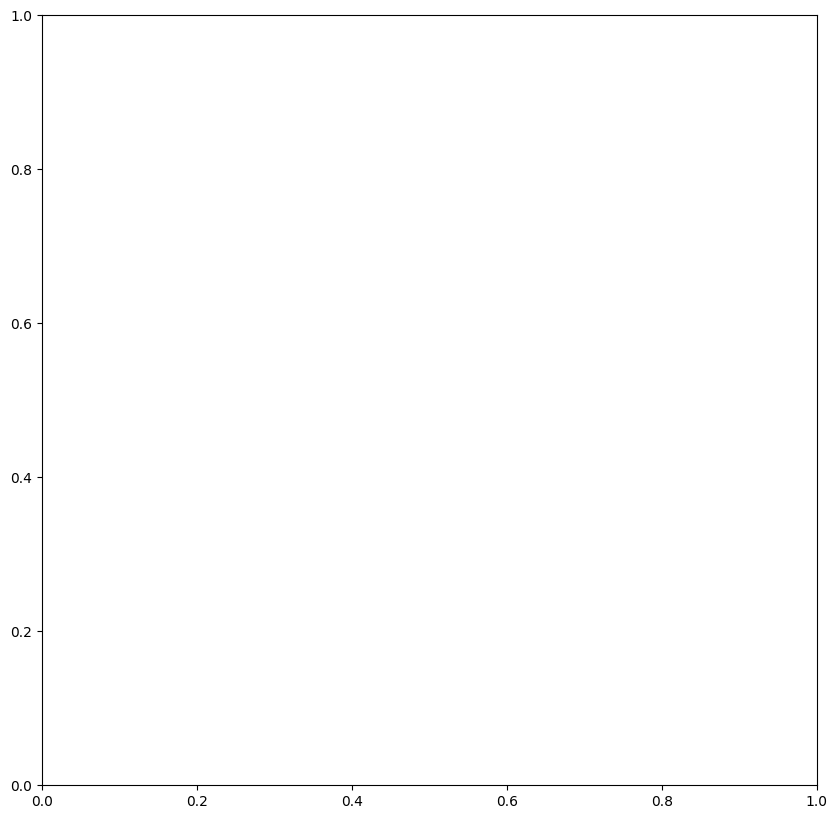

In [ ]:
import matplotlib.pyplot as plt

# Visualize the attention weights for the first layer (layer 0)
attention_weights_layer0 = attention_weights[0]

# Get the sentence tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())

# Plot the attention heatmap
plt.figure(figsize=(10, 10))
plt.imshow(attention_weights_layer0[0], cmap='viridis', aspect='auto', origin='lower')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel('Input Tokens')
plt.ylabel('Output Tokens')
plt.title('Attention Heatmap - Layer 0')
plt.colorbar()
plt.show()


In [ ]:
from bertviz import head_view
from transformers import RobertaTokenizer, RobertaModel
import torch

# Load the pre-trained RoBERTa model and tokenizer
model_version = 'roberta-base'
model = RobertaModel.from_pretrained('drive/MyDrive/fine_tuned_roberta', output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

# Define your text
text = "the product is so good."

# Tokenize the text
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

# Get the attention weights
outputs = model(**inputs)
attention = outputs[-1]  # Extract attention weights

# Visualize the attention
head_view(attention,tokens=tokens)


Some weights of RobertaModel were not initialized from the model checkpoint at drive/MyDrive/fine_tuned_roberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: ignored